<a href="https://colab.research.google.com/github/prasann-ranade/PUBH6859/blob/main/PUBH_6859_Assignment_4_Prasann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PUBH 6859: HPCC \
Prasann Ranade \
Assignment 4

# Part A: PubMed Visualization

This notebook will help you to visualize the sample output of searches trough the PubMed database.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import datetime

In [ ]:
def data_prep(dat_directory  = 'path-to-data/'):
    cn = 0
    for file in os.listdir(dat_directory + '/'):
        file_path = str(dat_directory + '/' + file)
        temp = pd.read_csv(file_path, skiprows=1, sep=',')
        temp.columns = ['year', 'count']
        temp.loc[:, 'omics'] = file.split('_')[0].split('.')[0]
        temp.loc[:, 'tech'] = file.split('_')[-1].split('.')[0]
        if cn == 0:
          df = temp.copy()
        else:
          df = pd.concat([df, temp], ignore_index=True)
        cn += 1
    return df


In [ ]:
def ncolors(n, colormap='cividis', custom_palette=None):
    """
    Utility for defining N evenly spaced colors across a color map or custom palette.
    :param n: number of colors to generate
    :param colormap: name of colormap to use (default: 'cividis')
    :param custom_palette: custom list of colors to use (default: None)
    :return: list of N colors
    """
    if custom_palette is not None:
        return custom_palette[:n]
    else:
        cmap = plt.get_cmap(colormap)
        cmap_max = cmap.N
        return [cmap(int(k * cmap_max / (n - 1))) for k in range(n)]

<Figure size 640x480 with 0 Axes>

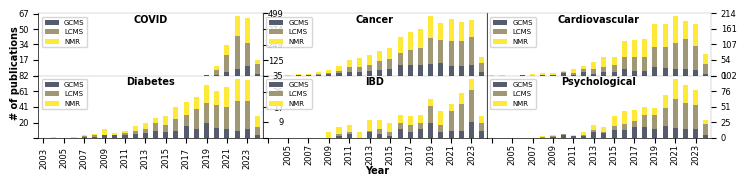

In [ ]:
drive_path =  '/content/drive/MyDrive/PubMed'
px = []
cn = 0
df_main = data_prep(dat_directory= drive_path + '/data')
name_list = list(set(df_main.loc[:, 'omics']))
name_list.sort()
min_year = df_main.loc[:, 'year'].min()
max_year = df_main.loc[:, 'year'].max()
temp_0 = pd.DataFrame(range(min_year, max_year+1), columns=['year'])
tech_list = list(df_main.loc[:, 'tech'])
tech_list.sort()
colors = ncolors(len(tech_list))
color_pal = {}
for n, tech in enumerate(tech_list):
  color_pal[tech] = colors[n]

fig=plt.figure()
fig = plt.figure(figsize=(7.2,1.6))
gs=GridSpec(4,6,wspace=0.0,hspace = 0.0)

for i in [0,2]:
    for j in [0,2,4]:
        temp = df_main.loc[df_main.loc[:, 'omics'] == name_list[cn], :]
        temp = pd.pivot_table(data=temp,
                              index=['year'],
                              columns=['tech'],
                              values='count').reset_index()
        df = temp_0.merge(temp, how = 'left')
        df.fillna(0, inplace=True)


        px.append(fig.add_subplot(gs[i:(i+2), j:(j+2)]))
        px[-1].tick_params(axis='both', which='major', labelsize=6)

        try:
            df.plot(x='year', kind='bar',
                    stacked = True, color= color_pal, ax = px[-1])
        except:
            pass
        plt.xlabel("")
        ymin, ymax = px[-1].get_ylim()

        px[-1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 0))
        px[-1].xaxis.set_tick_params(labelsize=6)
        px[-1].spines['top'].set_linewidth(0.1)
        px[-1].spines['left'].set_linewidth(0.5)
        px[-1].spines['right'].set_linewidth(0.1)
        px[-1].spines['bottom'].set_linewidth(0.5)
        px[-1].legend(loc ='upper left', fontsize = 5)

        if cn in [1, 4]:
            px[-1].tick_params(axis="y",direction="in", pad=-15)
        if cn in [2, 5]:
            px[-1].yaxis.tick_right()
        if cn <3:
            px[-1].yaxis.get_major_ticks()[0].label1.set_visible(False)
            px[-1].set_xticklabels([])
        else:
            px[-1].yaxis.get_major_ticks()[0].label1.set_visible(False)
            px[-1].set_xticks(px[-1].get_xticks()[::2])
            px[-1].xaxis.label.set_visible(False)
            if cn > 3:
                px[-1].xaxis.get_major_ticks()[0].label1.set_visible(False)
                px[-1].tick_params(axis="x",direction="out", pad=1)



        px[-1].xaxis.set_tick_params(labelsize=6)#COunt
        px[-1].yaxis.set_tick_params(labelsize=6)#Year


        px[-1].text(.5, .85, name_list[cn], transform=px[-1].transAxes, ha="center", weight='bold', size =7)
        cn += 1
fig.text(0.5, -0.03, 'Year', ha='center', fontsize = 7, weight='bold')
fig.text(-0.01, 0.6, '# of publications', va='center', rotation='vertical', fontsize = 7, weight='bold')
plt.tight_layout(pad=0.05)

fig.savefig(drive_path+"/supp1.pdf", dpi=600, bbox_inches = "tight")
fig.savefig(drive_path+"/supp1.png", dpi=600, bbox_inches = "tight")
plt.show()

# Part B: Python Scripts

Steps Taken:
1. Write scripts for setup and cleanup of EC2 and S3 services

In [ ]:
# setup_AWS.py

import boto3

# region: us-east-1
# AMI ID: ami-04e5276ebb8451442
# bucket name: hpc-assn4-new-bucket
# instance ID: i-08a770080535130a3

# Initialize boto3 clients for EC2 and S3
ec2_client = boto3.client('ec2', region_name='us-east-1')
s3_client = boto3.client('s3', region_name='us-east-1')

# Create an EC2 instance
def create_ec2_instance():
    instance = ec2_client.run_instances(
        ImageId='ami-04e5276ebb8451442',
        InstanceType='t2.micro',
        MinCount=1,
        MaxCount=1
    )
    return instance['Instances'][0]['InstanceId']

# Create an S3 bucket
def create_s3_bucket(bucket_name):
    s3_client.create_bucket(Bucket=bucket_name)

if __name__ == "__main__":
    # Create EC2 instance
    instance_id = create_ec2_instance()
    print("EC2 instance created with Instance ID:", instance_id)

    # Create S3 bucket
    bucket_name = 'hpc-assn4-new-bucket'
    create_s3_bucket(bucket_name)
    print("S3 bucket created with name:", bucket_name)


In [ ]:
# cleanup_AWS.py

import boto3

# region: us-east-1
# AMI ID: ami-04e5276ebb8451442
# bucket name: hpc-assn4-new-bucket
# instance ID: i-065f3baa5e82d0b7e

# Initialize boto3 clients for EC2 and S3
ec2_client = boto3.client('ec2', region_name='us-east-1')
s3_client = boto3.client('s3', region_name='us-east-1')

# Remove the EC2 instance
def remove_ec2_instance(instance_id):
    ec2_client.terminate_instances(InstanceIds=[instance_id])

# Remove the S3 bucket
def remove_s3_bucket(bucket_name):
    s3_client.delete_bucket(Bucket=bucket_name)

if __name__ == "__main__":
    instance_id = 'i-065f3baa5e82d0b7e'
    bucket_name = 'hpc-assn4-new-bucket's

    # Remove EC2 instance
    remove_ec2_instance(instance_id)
    print("EC2 instance with Instance ID:", instance_id, "removed")

    # Remove S3 bucket
    remove_s3_bucket(bucket_name)
    print("S3 bucket with name:", bucket_name, "removed")


2. Setup IAM Role for Boto3 to access EC2 and S3 services

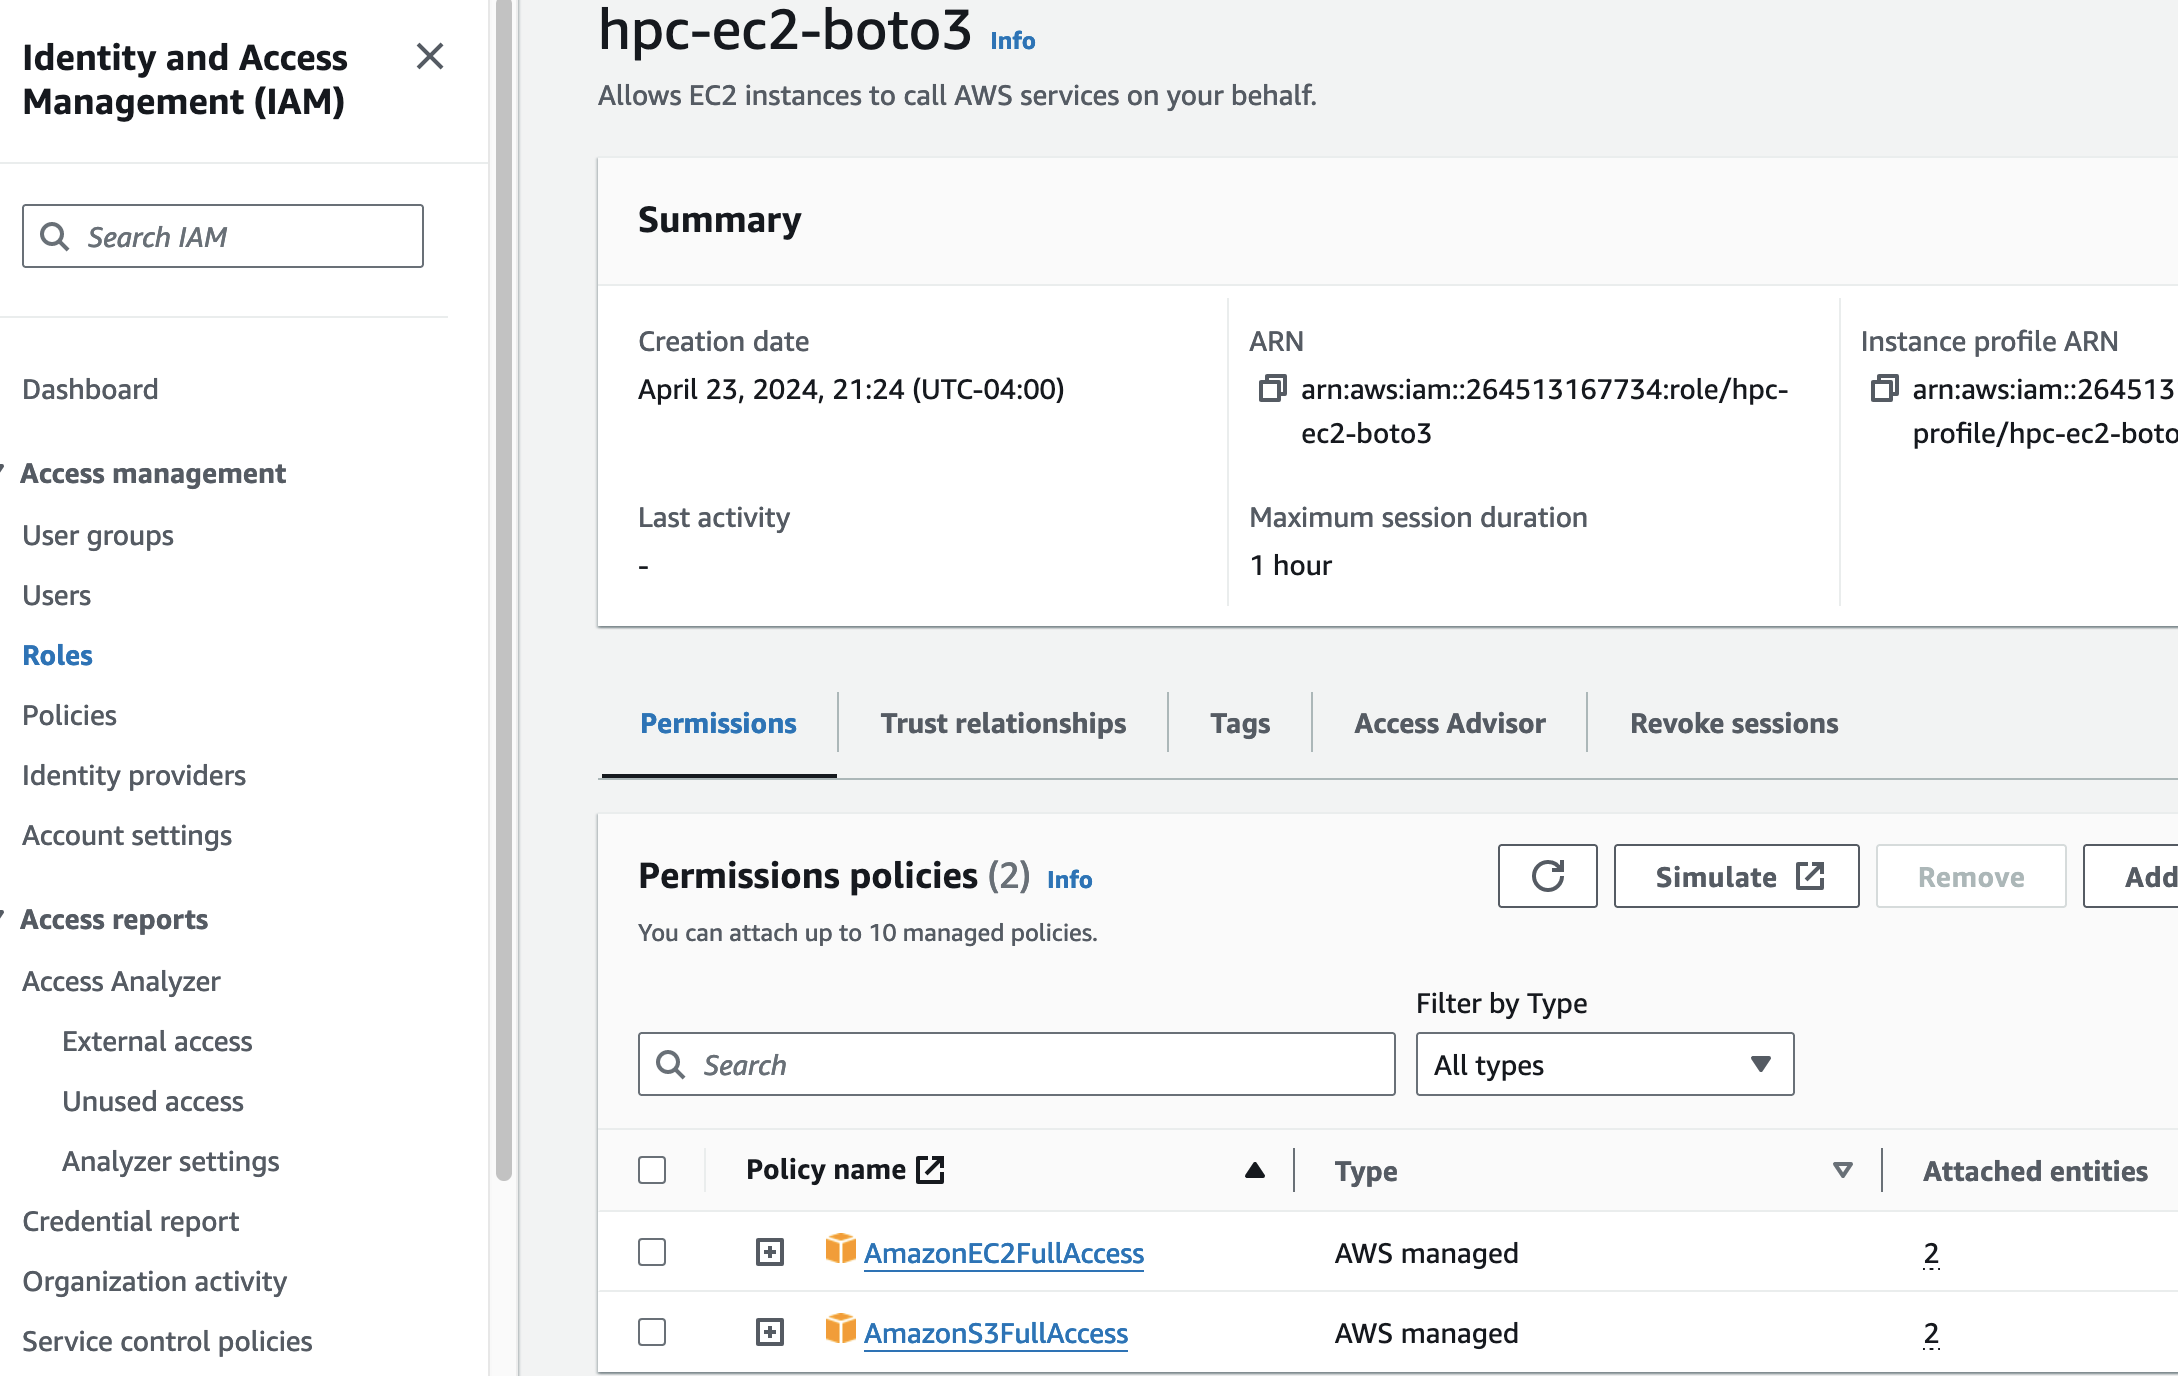

3. Connect to EC2 instance
4. Upload and run Python scripts

![](https://drive.google.com/uc?id=1QbannnetTNb5E_R-1rRmXPBS6DDNW7jW)

5.  Run setup_AWS.py script to create an EC2 instance and S3 bucket on AWS

![](https://drive.google.com/uc?id=1ajWV_BcEE2xP05O-iZHSWxDGD1ZpmKTR)

6. Verify creation of EC2 instance and S3 bucket

![](https://drive.google.com/uc?id=1jGaJIDIhluS5nyQ51suPN4GrgltJt6uR)

![](https://drive.google.com/uc?id=1ujQGdARVZSazR78G-7wTyTk8KWJbjotH)

7. Run cleanup_AWS.py script to delete EC2 instance and S3 bucket.

![](https://drive.google.com/uc?id=1C_PEu5XRLRzRVAP45kQbgPnaWNAW2lOR)